In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torch import optim
from torchvision import transforms
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, ds_dir, annotations_dir, transform=None):
        self.ds_dir = ds_dir
        self.img_notes = pd.read_csv(annotations_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.img_notes)

    def __getitem__(self, idx):
        img_path = self.img_notes.iloc[idx].example_path
        img = read_image(os.path.join(self.ds_dir, img_path))
        label = self.img_notes.iloc[idx].label
        if self.transform:
            img = self.transform(img)
        return img, label

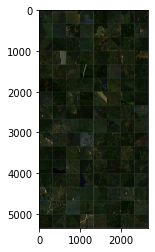

2 0 0 2 2 1 0 0 1 0 0 0 0 0 2 0 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 2 2 2 0 2 0 0 1 0 2 0 0 2 0 0 1 1 2 2 2 2 2 0 2 1 0 0 0 1 0 2 0 2 0 2 0 1 1 2 2 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 2 2 2 0 0 0 0 1 1 2 0 2 0 0 2 2 2 0 0 2 2 0 0 0 0 2 2 1 0 0 2 2 2 1 1 0 2 2 1 0


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(102400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(90)]
     )

batch_size = 2
learning_rate = 0.001

dataset = CustomDataset('', 'train.csv', transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, criterion, optimizer)
    test_loop(testloader, net, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.867667  [    0/ 1371]
loss: 0.840365  [  200/ 1371]
loss: 0.804577  [  400/ 1371]
loss: 1.331976  [  600/ 1371]
loss: 0.813472  [  800/ 1371]
loss: 0.814295  [ 1000/ 1371]
loss: 1.705130  [ 1200/ 1371]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.966793 

Epoch 2
-------------------------------
loss: 0.797177  [    0/ 1371]
loss: 0.841851  [  200/ 1371]
loss: 1.046436  [  400/ 1371]
loss: 1.303115  [  600/ 1371]
loss: 0.869556  [  800/ 1371]
loss: 0.877400  [ 1000/ 1371]
loss: 1.485085  [ 1200/ 1371]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.951355 

Epoch 3
-------------------------------
loss: 0.846899  [    0/ 1371]
loss: 0.833586  [  200/ 1371]
loss: 0.738620  [  400/ 1371]
loss: 1.488303  [  600/ 1371]
loss: 0.836543  [  800/ 1371]
loss: 0.828756  [ 1000/ 1371]
loss: 1.581750  [ 1200/ 1371]
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.951364 

Epoch 4
-------------------------------
loss: 0.828422  [    0/ 1371]
loss: 0.825238  [  200/ 